In [34]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class WordDataset(Dataset):
    def __init__(self, csv_path):
        # Load the data
        self.data = pd.read_csv(csv_path)
        
        # Preprocess the dataset to remove rows where correct_word or incorrect_word are not strings
        self.data = self.data[self.data['Correct Word'].apply(lambda x: isinstance(x, str))]
        self.data = self.data[self.data['Incorrect Word'].apply(lambda x: isinstance(x, str))]
        
        # Vocabulary setup
        self.vocab = "abcdefghijklmnopqrstuvwxyz"
        self.vocab_size = len(self.vocab) + 1
        self.ctoi = {char: idx for idx, char in enumerate(self.vocab)}
        
        # One-Hot Encoding
        self.create_OHE()

    def create_OHE(self):
        """Creates a One-Hot Encoding matrix for the vocabulary."""
        self.OHE = torch.zeros((self.vocab_size, self.vocab_size))
        for i in range(self.vocab_size):
            self.OHE[i, i] = 1

    def get_OHE(self, word):
        """Converts a word into a one-hot encoding tensor."""
        emb = [self.OHE[self.ctoi.get(char, self.vocab_size - 1)] for char in word]
        return torch.stack(emb)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns (correct_word, incorrect_word, target) as tensors."""
        correct_word = self.data.iloc[idx, 0].lower()
        incorrect_word = self.data.iloc[idx, 1].lower()
        target = torch.tensor([self.data.iloc[idx, 2]], dtype=torch.float32)
        return self.get_OHE(correct_word), self.get_OHE(incorrect_word), target

def collate_fn(batch):
    """Pads sequences in a batch to the max length in the batch."""
    corrects, incorrects, targets = zip(*batch)
    
    max_len = max(max(c.shape[0] for c in corrects), max(i.shape[0] for i in incorrects))

    pad_tensor = torch.zeros((max_len, corrects[0].shape[1]))  # (max_len, vocab_size)
    
    corrects_padded = [torch.cat((c, pad_tensor[:max_len - c.shape[0]]), dim=0) for c in corrects]
    incorrects_padded = [torch.cat((i, pad_tensor[:max_len - i.shape[0]]), dim=0) for i in incorrects]
    
    return torch.stack(corrects_padded), torch.stack(incorrects_padded), torch.stack(targets)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=300, num_epochs=15, lr=0.001):
        super().__init__()

        self.vocab = "abcdefghijklmnopqrstuvwxyz"
        self.vocab_size = len(self.vocab) + 1
        self.ctoi = {char: idx for idx, char in enumerate(self.vocab)}

        self.num_epochs = num_epochs
        self.vocab_size = vocab_size
        self.lstm1 = nn.LSTM(input_size=self.vocab_size, hidden_size=emb_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, batch_first=True)
        self.fc = nn.Linear(1, 1)

        self.loss_fn = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)  

        
        self.create_OHE()

    def create_OHE(self):
        """Creates a One-Hot Encoding matrix for the vocabulary."""
        self.OHE = torch.zeros((self.vocab_size, self.vocab_size))
        for i in range(self.vocab_size):
            self.OHE[i, i] = 1

    def get_OHE(self, word):
        """Converts a word into a one-hot encoding tensor."""
        emb = [self.OHE[self.ctoi.get(char, self.vocab_size - 1)] for char in word]
        return torch.stack(emb)
    
    def fit(self, batched_data):
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            for x1, x2, target_batch in batched_data:
                x1, x2, target_batch = x1.to(self.device), x2.to(self.device), target_batch.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.forward(x1, x2)
                loss = self.loss_fn(outputs, target_batch)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            print(f"{epoch+1}/{self.num_epochs} - Loss: {epoch_loss / len(batched_data)}")

    def get_embedding(self, x):
        out1, _ = self.lstm1(x)
        out2, (hn, _) = self.lstm2(out1)
        return hn.squeeze(0) 

    def forward(self, x1, x2):
        emb1 = self.get_embedding(x1)
        emb2 = self.get_embedding(x2)

        diff = emb1 - emb2
        squared_norm = torch.sum(diff ** 2, dim=1, keepdim=True)

        out = torch.sigmoid(self.fc(squared_norm))
        return out
    
    def save_model(self, model_name):
        torch.save(self.state_dict(), model_name)
        print(f"Model saved to {model_name}")

    def load_model(self, model_name):
        self.load_state_dict(torch.load(model_name))
        self.eval()  # Set the model to evaluation mode after loading
        print(f"Model loaded from {model_name}")


In [4]:
csv_path = "Most Used Words Combinations.csv"

dataset = WordDataset(csv_path)  
batch_size = 128

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for correct_batch, incorrect_batch, target_batch in dataloader:
    print(f"Correct words batch shape: {correct_batch.shape}")  
    print(f"Incorrect words batch shape: {incorrect_batch.shape}")  
    print(f"Target batch shape: {target_batch.shape}")  
    break

Correct words batch shape: torch.Size([128, 10, 27])
Incorrect words batch shape: torch.Size([128, 10, 27])
Target batch shape: torch.Size([128, 1])


In [5]:
model = CustomModel()
model.fit(dataloader)

1/15 - Loss: 0.25541764996663685
2/15 - Loss: 0.12110359608334557
3/15 - Loss: 0.03125339357736224
4/15 - Loss: 0.013847110793557346
5/15 - Loss: 0.00743902897325102
6/15 - Loss: 0.004529161706599081
7/15 - Loss: 0.0031438373739895503
8/15 - Loss: 0.002287920798744637
9/15 - Loss: 0.0017852973115644426
10/15 - Loss: 0.0014756512419492264
11/15 - Loss: 0.0012806655554461375
12/15 - Loss: 0.0010927410173642111
13/15 - Loss: 0.001008095143717801
14/15 - Loss: 0.0009064525857007908
15/15 - Loss: 0.0008074279022864302


In [ ]:
model.save_model("char2vec.pth.pth")

Model saved to char2vec.pth


In [51]:
loaded_model = CustomModel() 
loaded_model.load_model("char2vec.pth")
loaded_model

Model loaded from char2vec.pth


C:\Users\LEGION\AppData\Local\Temp\ipykernel_14004\491611779.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_name))


CustomModel(
  (lstm1): LSTM(27, 300, batch_first=True)
  (lstm2): LSTM(300, 300, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (loss_fn): L1Loss()
)

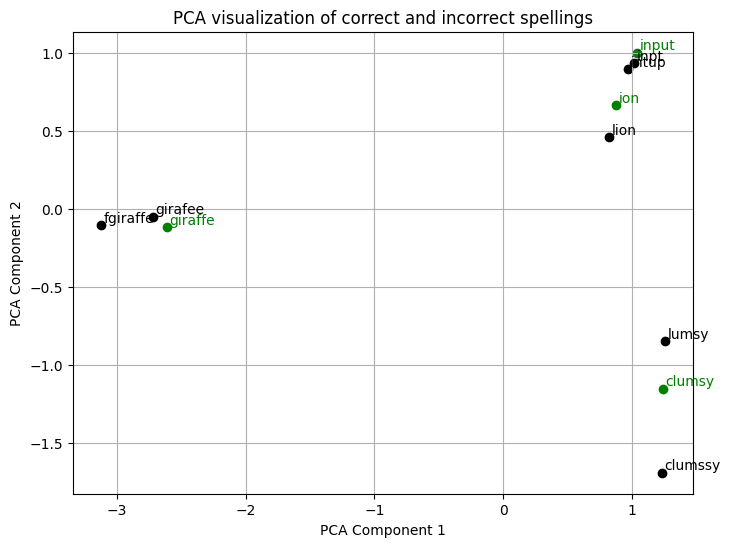

In [63]:
correct_words = ['input', 'clumsy', 'giraffe',"ion"]
incorrect_words = ['inpt', 'girafee', 'clumssy', 'fgiraffe', 'lumsy', "intup","lion",]

correct_embeddings = [loaded_model.get_embedding(loaded_model.get_OHE(word).to(model.device)) for word in correct_words]
incorrect_embeddings = [loaded_model.get_embedding(loaded_model.get_OHE(word).to(model.device)) for word in incorrect_words]

all_embeddings = correct_embeddings + incorrect_embeddings

flattened_embeddings = [emb.flatten().cpu().detach().numpy() for emb in all_embeddings]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_embeddings)

plt.figure(figsize=(8, 6))

for i, (word, color) in enumerate(zip(correct_words + incorrect_words, ['green'] * len(correct_words) + ['black'] * len(incorrect_words))):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=color)
    plt.text(pca_result[i, 0] + 0.02, pca_result[i, 1] + 0.02, word, color=color)

plt.title("PCA visualization of correct and incorrect spellings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()